In [98]:
%matplotlib notebook
import numpy as np
import matplotlib
from astropy.table import Table, vstack, join
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from astropy.coordinates import SkyCoord
import astropy.units as u
import plotting_resources as res
import linmix
plt.rc('text', usetex=True)
plt.ioff()

rauto_cut = 22.9
MB_cut = -19.2
frauto_cut = 10**((rauto_cut-23.9)/(-2.5))
f_contam = 0.30*0.122 # 30% times the outlier rate for Q=4
f_close = 0.18 # Correction due to the max slit density

## Load the catalogs

In [33]:
slitcat = Table().read('../catalogs/personal_catalogs/slits_phot_zs_cutonslitdist_rcl.csv', format='csv')
ldpcat = slitcat[np.where((slitcat['Q'] >= 4) & 
                          (slitcat['slit_distance'] < 1.0))]
cllist = res.load_clusters()

rfmags = Table().read('../catalogs/eazy_colors/ediscs_zldp_zfors_EAzY_outputs.csv', format='csv')
rfmags.rename_column('id', 'ids')

ldpcat = join(ldpcat, rfmags['ids','MAG_AB_rfB', 'MAG_AB_rfU'], keys='ids', join_type='left')
ldpcat['UB_color'] = ldpcat['MAG_AB_rfU'] - ldpcat['MAG_AB_rfB']

ldpcat = ldpcat[np.where(ldpcat['MAG_AB_rfB'] < MB_cut)]

In [34]:
print(cllist[0])

 D_A   count   dec          m200         papername   r200    ra   rinfall sigma sigma_hi sigma_lo tablename   z           cmr        
------ ----- ------- ----------------- ------------- ---- ------- ------- ----- -------- -------- --------- ------ ------------------
1222.2     1 -12.198 153000000000000.0 cl1018.8-1211 0.93 154.695    3.06 486.0     59.0     63.0    CL1018 0.4734 1.3661369460326191


## Loop over clusters to calculate $N_{infall} = N_{phot}\frac{N_{memb}}{N_{slits}}(1-f_{contam})$
Save $N_{infall}$ in the dictionary

In [35]:
print(len(ldpcat))

11596


In [36]:
cllist['Ninfall'] = 0.0
cllist['Ninfall_upper_limit'] = 0.0
cllist['Ninfall_lower_limit'] = 0.0

In [37]:
for cl in cllist:
    # Calculate Nslits and Nmemb
    subcat = ldpcat[np.where(ldpcat['field'] == cl['tablename'])]
    Nslits = float(len(subcat[np.where((subcat['d_cl_mpc'] > cl['r200']) & 
                                       (subcat['d_cl_mpc'] < cl['rinfall']))]))
    Nmemb = float(len(subcat[np.where((subcat['d_cl_mpc'] > cl['r200']) & 
                                      (subcat['d_cl_mpc'] < cl['rinfall']) & 
                                      (abs(subcat['zLDP']-cl['z']) < 0.02))]))

    # Load the relevant photometry
    photo = Table().read('../catalogs/ediscs_v7.0/{}_catalog_v7.0.fits'.format(cl['tablename']))
    res.calc_mag(photo, 'Rauto')
    photo = photo[np.where(photo['Rauto'] <= rauto_cut)]
    
    # Calculate d_cl for each photometry obj
    center = SkyCoord(cl['ra']*u.degree, cl['dec']*u.degree)
    objs = SkyCoord(photo['ra']*u.degree, photo['dec']*u.degree)
    photo['d_cl_mpc'] = center.separation(objs).radian*cl['D_A']
    Nphot = float(len(photo[np.where((photo['d_cl_mpc'] > cl['r200']) &
                                     (photo['d_cl_mpc'] < cl['rinfall']))]))
    
    
    Ninfall = Nphot * (Nmemb/Nslits) * (1-f_contam)
    cl['Ninfall'] = Ninfall
    
    # Calculate the error bars
    dNpu = res.upper_limit(Nphot)-Nphot
    dNmu = res.upper_limit(Nmemb)-Nmemb
    dNsu = res.upper_limit(Nslits)-Nslits
    cl['Ninfall_upper_limit'] = Ninfall * np.sqrt((dNpu/Nphot)**2 + (dNmu/Nmemb)**2 + (dNsu/Nslits)**2)
    
    dNpl = Nphot-res.lower_limit(Nphot)
    dNml = Nmemb-res.lower_limit(Nmemb)
    dNsl = Nslits-res.lower_limit(Nslits)
    cl['Ninfall_lower_limit'] = Ninfall * np.sqrt((dNpl/Nphot)**2 + (dNml/Nmemb)**2 + (dNsl/Nslits)**2)

/Users/matthewkirby/galaxy_evolution/just2017plots/plotting_resources.py:6: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(f) + 23.9


In [38]:
# Fit the relation
lnx = np.log(cllist['sigma'])
sigma_errs = (cllist['sigma_hi'] + cllist['sigma_lo'])/2
lnx_errs = np.log(cllist['sigma']+sigma_errs) - lnx

lny = np.log(cllist['Ninfall'])
Ninfall_errs = (cllist['Ninfall_upper_limit'] + cllist['Ninfall_lower_limit'])/2
lny_errs = np.log(cllist['Ninfall']+Ninfall_errs) - lny

lm = linmix.LinMix(lnx, lny, lnx_errs, lny_errs, K=2)
lm.run_mcmc(silent=True)

infall_slope_mean = np.mean(lm.chain['beta'])
infall_slope_std = np.sqrt(np.var(lm.chain['beta']))

In [39]:
fit_xs = np.arange(0, 1500, 20)
fit_infall_ys = np.exp(np.mean(lm.chain['alpha']))*fit_xs**infall_slope_mean

## Loop over clusters to calculate $N_{cluster} = N_{phot}\frac{N_{memb}}{N_{slits}}(1-f_{contam})\frac{1}{f_{close}}$
Save $N_{cluster}$ in the dictionary

In [40]:
cllist['Ncluster'] = 0.0
cllist['Ncluster_upper_limit'] = 0.0
cllist['Ncluster_lower_limit'] = 0.0

In [41]:
for cl in cllist:
    # Calculate Nslits and Nmemb
    subcat = ldpcat[np.where(ldpcat['field'] == cl['tablename'])]
    Nslits = float(len(subcat[np.where(subcat['d_cl_mpc'] < cl['r200'])]))
    Nmemb = float(len(subcat[np.where((subcat['d_cl_mpc'] < cl['r200']) & 
                                      (abs(subcat['zLDP']-cl['z']) < 0.02))]))

    # Load the relevant photometry
    photo = Table().read('../catalogs/ediscs_v7.0/{}_catalog_v7.0.fits'.format(cl['tablename']))
    res.calc_mag(photo, 'Rauto')
    photo = photo[np.where(photo['Rauto'] <= rauto_cut)]
    
    # Calculate d_cl for each photometry obj
    center = SkyCoord(cl['ra']*u.degree, cl['dec']*u.degree)
    objs = SkyCoord(photo['ra']*u.degree, photo['dec']*u.degree)
    photo['d_cl_mpc'] = center.separation(objs).radian*cl['D_A']
    Nphot = float(len(photo[np.where(photo['d_cl_mpc'] < cl['r200'])]))
    
    Ncluster = Nphot * (Nmemb/Nslits) * (1-f_contam) * (1./f_close)
    cl['Ncluster'] = Ncluster

    if Ncluster == 0.0:
        cl['Ncluster_upper_limit'] = 0.0
        cl['Ncluster_lower_limit'] = 0.0
        continue
    
    # Calculate the error bars
    dNpu = res.upper_limit(Nphot)-Nphot
    dNmu = res.upper_limit(Nmemb)-Nmemb
    dNsu = res.upper_limit(Nslits)-Nslits
    cl['Ncluster_upper_limit'] = Ncluster * np.sqrt((dNpu/Nphot)**2 + (dNmu/Nmemb)**2 + (dNsu/Nslits)**2)
    
    dNpl = Nphot-res.lower_limit(Nphot)
    dNml = Nmemb-res.lower_limit(Nmemb)
    dNsl = Nslits-res.lower_limit(Nslits)
    cl['Ncluster_lower_limit'] = Ncluster * np.sqrt((dNpl/Nphot)**2 + (dNml/Nmemb)**2 + (dNsl/Nslits)**2)

/Users/matthewkirby/galaxy_evolution/just2017plots/plotting_resources.py:6: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(f) + 23.9


In [42]:
# Fit the relation
lnx = np.log(cllist['sigma'])
sigma_errs = (cllist['sigma_hi'] + cllist['sigma_lo'])/2
lnx_errs = np.log(cllist['sigma']+sigma_errs) - lnx

lny = np.log(cllist['Ncluster'])
Ncluster_errs = (cllist['Ncluster_upper_limit'] + cllist['Ncluster_lower_limit'])/2
lny_errs = np.log(cllist['Ncluster'] + Ncluster_errs) - lny

idxs = np.where(lny > 0.)
lm2 = linmix.LinMix(lnx[idxs], lny[idxs], lnx_errs[idxs], lny_errs[idxs], K=2)
lm2.run_mcmc(silent=True)

cluster_slope_mean = np.mean(lm2.chain['beta'])
cluster_slope_std = np.sqrt(np.var(lm2.chain['beta']))

/Users/matthewkirby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/matthewkirby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/matthewkirby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  


In [43]:
fit_cluster_ys = np.exp(np.mean(lm2.chain['alpha']))*fit_xs**cluster_slope_mean

## Calculate the ratio (and error bar) of the two quantities

In [44]:
cllist['Nratio'] = 0.0
cllist['Nratio_upper_limit'] = 0.0
cllist['Nratio_lower_limit'] = 0.0
for cl in cllist:
    if cl['Ncluster'] < 1:
        cl['Nratio'] = 0
        cl['Nratio_upper_limit'] = 0
        cl['Nratio_lower_limit'] = 0
        continue
        
    Nratio = float(cl['Ninfall'])/cl['Ncluster']
    upper = Nratio * np.sqrt((cl['Ninfall_upper_limit']/cl['Ninfall'])**2 +
                             (cl['Ncluster_upper_limit']/cl['Ncluster'])**2)
    lower = Nratio * np.sqrt((cl['Ninfall_lower_limit']/cl['Ninfall'])**2 +
                             (cl['Ncluster_lower_limit']/cl['Ncluster'])**2)
    cl['Nratio'] = Nratio
    cl['Nratio_upper_limit'] = upper
    cl['Nratio_lower_limit'] = lower

# Make figure 8

In [45]:
cltable = Table(cllist)

In [46]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

<IPython.core.display.Javascript object>


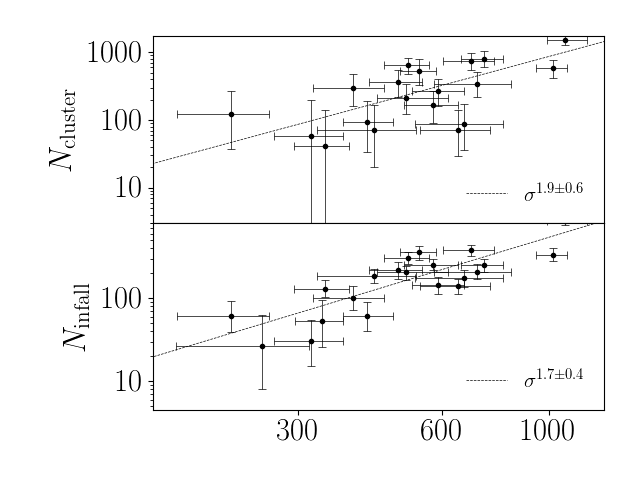

In [16]:
f, (a1, a2) = plt.subplots(2,1, sharex=True)
esize = 0.5

# Top plot
a1.errorbar(cltable['sigma'], cltable['Ncluster'],
            yerr=[cltable['Ncluster_lower_limit'], cltable['Ncluster_upper_limit']],
            xerr=[cltable['sigma_lo'], cltable['sigma_hi']],
            fmt='.k', capsize=3, elinewidth=esize, capthick=esize, label=None);
a1.plot(fit_xs, fit_cluster_ys, '--k', lw=0.5,
        label=r'$\sigma^{{ {:.1f} \pm {:.1f} }}$'.format(cluster_slope_mean, cluster_slope_std))

# Bottom plot
a2.errorbar(cltable['sigma'], cltable['Ninfall'],
            yerr=[cltable['Ninfall_lower_limit'], cltable['Ninfall_upper_limit']],
            xerr=[cltable['sigma_lo'], cltable['sigma_hi']],
            fmt='.k', capsize=3, elinewidth=esize, capthick=esize, label=None);
a2.plot(fit_xs, fit_infall_ys, '--k', lw=0.5,
        label=r'$\sigma^{{ {:.1f} \pm {:.1f} }}$'.format(infall_slope_mean, infall_slope_std))

#a1.set_ylim(9, 3000);
#a1.set_xlim(150, 1500);

In [17]:
a1.legend(loc=4, frameon=False, fontsize=15)
a2.legend(loc=4, frameon=False, fontsize=15)

a2.set_yscale('log')
a1.set_yscale('log')
a1.set_xscale('log')

a1.set_ylabel(r'$N_{\rm{cluster}}$');
a2.set_ylabel(r'$N_{\rm{infall}}$');
#a2.set_xlabel(r'$\sigma\;(\rm{km\; s^{-1}})$');

a2.xaxis.set_minor_locator(ticker.FixedLocator([]))
a2.xaxis.set_ticks([300, 600, 1000])
a1.yaxis.set_ticks([10, 100, 1000])
a1.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
a2.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
a2.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.tight_layout()
f.subplots_adjust(hspace=0)

a1.set_xlim(150, 1300)
a1.set_ylim(3, 1700)
a2.set_ylim(4.5, 800)

(4.5, 800)

In [18]:
plt.savefig('plots/richness_vs_veldisp.eps', dpi=300)
#plt.clf()

# Make figure 9

In [99]:
fig = plt.figure(figsize=(8, 5))
a = fig.gca()
a.errorbar(cltable['sigma'], cltable['Nratio'],
             xerr=[cltable['sigma_lo'], cltable['sigma_hi']],
             yerr=[cltable['Nratio_lower_limit'], cltable['Nratio_upper_limit']],
             fmt='.k', capsize=3, elinewidth=esize, capthick=esize);

xlims = a.get_xlim()
a.fill_between(x=(xlims), y1=(.74, .74), y2=(.33, .33), color='silver')


# Format the plot
#a = plt.gca()
a.set_yscale('log')

a.set_ylabel(r'$N_{\rm{infall}}/N_{\rm{cluster}}$');
a.set_xlabel(r'$\sigma\;(\rm{km\; s^{-1}})$');

a.yaxis.set_ticks([0.1, 1, 10])
a.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
a.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

# Make right axis
ar = a.twinx()
ar.set_yscale('log')
ar.set_ylim(a.get_ylim())
ar.yaxis.set_minor_locator(ticker.FixedLocator([]))
ar.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ar.yaxis.set_ticklabels([.09, .09, .09, .5, .9])
ar.set_ylabel(r'$N_{\rm{infall}}/(N_{\rm{cluster}} + N_{\rm{infall}})$',
              rotation=270, labelpad=30)

fig.tight_layout()

In [100]:
plt.savefig('plots/richnessratio_vs_veldisp.eps', dpi=300)

In [71]:
meanr = np.mean(cltable['Nratio'])
growth = meanr/(meanr+1.)
growth**-1

2.089881578895309